# Beamforming With Optimized Scans
vbeam is built on top of high-level abstractions — we write Numpy-like code, wrap it with `jax.jit`, and hope for the best. We therefore do not have access to the same low-level optimizations that we would have if the beamformer was written in a language like C++ and CUDA. We are limited to high-level optimizations. One such optimization is simply doing less work. By filtering out redundant points from the scan, _before beamforming_, we can get a much faster beamformer. In this notebook we will explore how to perform such an optimization/pre-processing in vbeam.

The dataset used is a phased array, focused transmit, cardiac dataset, consisting of 64 elements, and 101 transmit events [1]. Since it is a phased array, we use a sector scan with 256 azimuths and 512 depth samples.

Let's (download and) import it!

_[1] A. Rodriguez-Molares, O. M. H. Rindal, O. Bernard, etal., “The UltraSound ToolBox,” in 2017 IEEE International Ultrasonics Symposium (IUS), ISSN: 1948-5727,Sep. 2017, pp. 1–4. DOI: 10 . 1109 / ULTSYM . 2017 .8092389._


In [1]:
import jax.numpy as np
import pyuff_ustb as pyuff

from vbeam.data_importers import import_pyuff
from vbeam.scan import sector_scan
from vbeam.util.download import cached_download

# Download and read the channel data
data_url = "http://www.ustb.no/datasets/Verasonics_P2-4_parasternal_long_small.uff"
uff = pyuff.Uff(cached_download(data_url))
channel_data = uff.read("/channel_data")

# Import the data
setup = import_pyuff(channel_data, frames=0)

# Define and set a custom sector scan
scan_angles = np.array([wave.source.azimuth for wave in channel_data.sequence])
scan_depths = np.linspace(0, 110e-3, 512)
scan = sector_scan(scan_angles, scan_depths).resize(azimuths=256)
setup.scan = scan

## Beamforming the Full Sector Scan
Let's create a basic DAS beamformer from our setup, run it on our imported data, and plot the result. We also time the beamformer. By calling `.block_until_ready()` on the result, we ensure that not more than one beamforming job is running at the same time on the GPU.

465 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


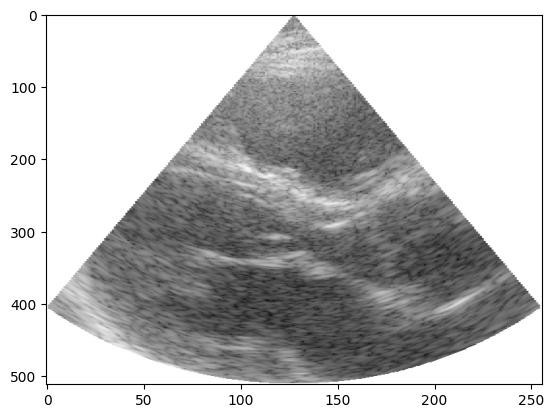

In [2]:
import jax
import matplotlib.pyplot as plt

from vbeam.beamformers import get_das_beamformer

beamformer = jax.jit(get_das_beamformer(setup))  # jax.jit makes it run fast
result = beamformer(**setup.data)
plt.imshow(result.T, aspect="auto", cmap="gray")

data = setup.data
%timeit beamformer(**data).block_until_ready()

Running on an Nvidia A100 40GB GPU, the average elapsed time came out to be `463 ms ± 1.17 ms`.

Let's explore how much work is being done. There are 101 transmits, 64 receiving elements, and 256x512 pixels. This amounts to having to process 101x64x256x512 ≈ 0.85 billion points. In 463 milliseconds, that approximately amounts to 1.8 billion points per second. This is fairly low for vbeam, and is likely due to a memory bottleneck.

In [3]:
from math import prod

dimension_sizes = setup.size(["transmits", "receivers", "points"])
total_points = prod(dimension_sizes)
print(f"Total number of processed points: {total_points:.1e}")
print(f"Points processed per second: {total_points/0.463:.1e}")

Total number of processed points: 8.5e+08
Points processed per second: 1.8e+09


## Filtering out Points by Apodization
We are beamforming using RTB, which means that most pixels are weighted by 0 for each transmit. By using a `ApodizationFilteredScan` (that wraps our original scan) we only beamform the pixels that are actually included by RTB.

/home/magnusk/vbeam/vbeam/data_importers/setup.py:45: UserWarning: point_position will be overwritten by the scan.
  warnings.warn("point_position will be overwritten by the scan.")


16.4 ms ± 657 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


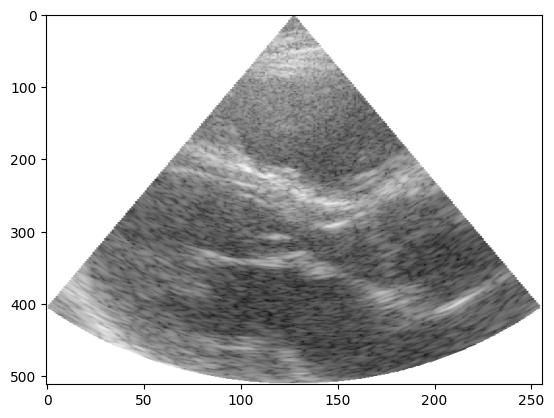

In [4]:
from vbeam.scan import ApodizationFilteredScan

setup.scan  = ApodizationFilteredScan.from_setup(setup, ["transmits", "points"])

beamformer = jax.jit(get_das_beamformer(setup))
result = beamformer(**setup.data)
plt.imshow(result.T, aspect="auto", cmap="gray")

data = setup.data
%timeit beamformer(**data).block_until_ready()

Now, the average elapsed time goes down to `16.8 ms ± 248 µs`; more than 27 times faster! This beamformer only have to process around a quarter of the pixels per transmit, for a total of 0.22 billion points. It processes around 13 billion points per second, which is actually 7 times more **efficient** — likely due to needing less memory, freeing up the memory bottleneck. 

In [5]:
dimension_sizes = setup.size(["transmits", "receivers", "points"])
total_points = prod(dimension_sizes)
print(f"Total number of processed points: {total_points:.1e}")
print(f"Points processed per second: {total_points/0.017:.1e}")

Total number of processed points: 2.2e+08
Points processed per second: 1.3e+10


## Scan Converting the Sector Scan Before Beamforming
A final optimization that we will explore in this notebook is to scan convert the sector scan _before beamforming_. There are a lot of resolution redundancy close to the aperture of a sector scan, as the points are so close together. If we scan convert the grid before beamforming, these redundant pixels are merged together. Additionally, as the RTB apodization is quite wide close to the aperture, we get even more (relative) redundancy. We can combine the scan conversion and apodization filtering optimizations for an effect that it greater than the sum of its parts.

5.69 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


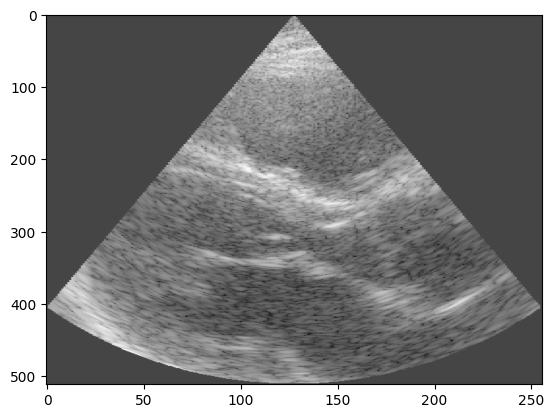

In [6]:
from vbeam.scan import ScanConvertedSectorScan

# Use both apodization filtering and scan conversion
setup.scan.base_scan = ScanConvertedSectorScan(scan)

beamformer = jax.jit(get_das_beamformer(setup))
result = beamformer(**setup.data)
plt.imshow(result.T, aspect="auto", cmap="gray")

data = setup.data
%timeit beamformer(**data).block_until_ready()

Using both the apodization filtering and pre scan conversion optimizations, the beamformer now takes `5.88 ms ± 155 µs`, on average. There are far fewer points as well, only about 7% of the original scan, or 26% of the apodization filtered scan. This beamformer processes around 9.7 billion points per second; slightly lower than the previous one, almost certainly due to under-utilizing the GPU cores. According to the `nvidia-smi` command, this beamformer had around 70% GPU utilization, while the previous one had around 90%.

In [7]:
dimension_sizes = setup.size(["transmits", "receivers", "points"])
total_points = prod(dimension_sizes)
print(f"Total number of processed points: {total_points:.1e}")
print(f"Points processed per second: {total_points/0.006:.1e}")

Total number of processed points: 5.8e+07
Points processed per second: 9.7e+09
